## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [10]:
import string
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('/content/drive/MyDrive/Colab/sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()
out = text

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2025-12-14 17:57:29--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2025-12-14 17:57:29 (60.5 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = "".join(text).lower()
print("Onegin length:", len(text))

Onegin length: 141888


Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: ch for i, ch in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_id  = {ch: i for i, ch in idx_to_token.items()}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
# Your code here

# for compatibility with generate_sample() below
device = torch.device("cpu")

SEQ_LENGTH = 40
MAX_LENGTH = 500

BATCH_SIZE = 64
HIDDEN_SIZE = 128
EPOCHS = 30
STEPS_PER_EPOCH = 200
LR = 1e-2
GRAD_CLIP = 1.0

n_tokens = len(tokens)

def make_batch(text_string, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH):
    max_start = len(text_string) - (seq_length + 1)
    starts = np.random.randint(0, max_start, size=batch_size)

    x = np.stack([ [token_to_id[ch] for ch in text_string[s : s + seq_length]] for s in starts ])
    y = np.stack([ [token_to_id[ch] for ch in text_string[s + 1 : s + seq_length + 1]] for s in starts ])

    x = torch.tensor(x, dtype=torch.long, device=device)
    y = torch.tensor(y, dtype=torch.long, device=device)
    return x, y

class CharRNN(nn.Module):
    def __init__(self, n_tokens, hidden_size):
        super().__init__()
        self.n_tokens = n_tokens
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_tokens + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_tokens + hidden_size, n_tokens)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=device)

    def forward(self, x_t, h_t):
        x_oh = F.one_hot(x_t, num_classes=self.n_tokens).float()
        combined = torch.cat([x_oh, h_t], dim=1)
        h_next = torch.tanh(self.i2h(combined))
        logits = self.i2o(combined)
        return logits, h_next

def train_char_model(model, text_string, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, lr=LR):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        for _ in range(steps_per_epoch):
            x, y = make_batch(text_string)
            h = model.initial_state(batch_size=x.size(0))

            loss = 0.0
            for t in range(x.size(1)):
                logits, h = model(x[:, t], h)
                loss = loss + loss_fn(logits, y[:, t])

            loss = loss / x.size(1)

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()

            epoch_loss += loss.item()

        epoch_loss /= steps_per_epoch
        history.append(epoch_loss)
        print(f"Epoch {epoch:02d}/{epochs} | loss = {epoch_loss:.4f}")

    return history

char_rnn = CharRNN(n_tokens=n_tokens, hidden_size=HIDDEN_SIZE)
loss_history_rnn = train_char_model(char_rnn, out)

Epoch 01/30 | loss = 2.3135
Epoch 02/30 | loss = 1.9688
Epoch 03/30 | loss = 1.8739
Epoch 04/30 | loss = 1.8258
Epoch 05/30 | loss = 1.7860
Epoch 06/30 | loss = 1.7600
Epoch 07/30 | loss = 1.7474
Epoch 08/30 | loss = 1.7292
Epoch 09/30 | loss = 1.7190
Epoch 10/30 | loss = 1.7057
Epoch 11/30 | loss = 1.7004
Epoch 12/30 | loss = 1.6933
Epoch 13/30 | loss = 1.6880
Epoch 14/30 | loss = 1.6850
Epoch 15/30 | loss = 1.6837
Epoch 16/30 | loss = 1.6783
Epoch 17/30 | loss = 1.6723
Epoch 18/30 | loss = 1.6718
Epoch 19/30 | loss = 1.6732
Epoch 20/30 | loss = 1.6709
Epoch 21/30 | loss = 1.6697
Epoch 22/30 | loss = 1.6692
Epoch 23/30 | loss = 1.6672
Epoch 24/30 | loss = 1.6622
Epoch 25/30 | loss = 1.6696
Epoch 26/30 | loss = 1.6675
Epoch 27/30 | loss = 1.6675
Epoch 28/30 | loss = 1.6653
Epoch 29/30 | loss = 1.6661
Epoch 30/30 | loss = 1.6667


Plot the loss function (axis X: number of epochs, axis Y: loss function).

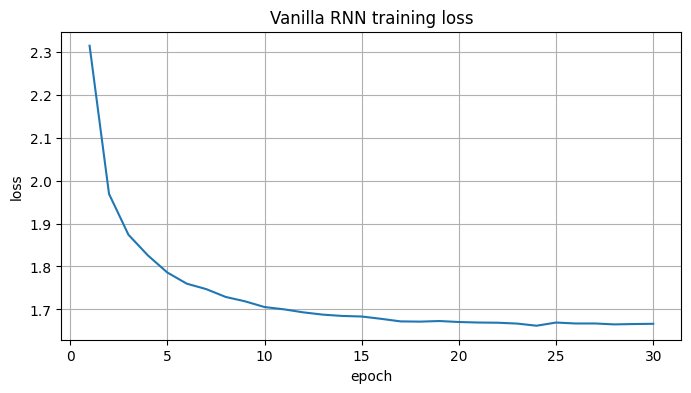

In [12]:
# Your plot code here

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history_rnn) + 1), loss_history_rnn)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Vanilla RNN training loss")
plt.grid(True)
plt.show()

In [28]:
# did small adjustments to this function
# changed x_sequence[:, -1] to x_sequence[:, i]

def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, i].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

Epoch 01/20 | loss = 2.0041
Epoch 02/20 | loss = 1.6255
Epoch 03/20 | loss = 1.5291
Epoch 04/20 | loss = 1.4652
Epoch 05/20 | loss = 1.4206
Epoch 06/20 | loss = 1.3842
Epoch 07/20 | loss = 1.3516
Epoch 08/20 | loss = 1.3251
Epoch 09/20 | loss = 1.3018
Epoch 10/20 | loss = 1.2795
Epoch 11/20 | loss = 1.2586
Epoch 12/20 | loss = 1.2418
Epoch 13/20 | loss = 1.2250
Epoch 14/20 | loss = 1.2070
Epoch 15/20 | loss = 1.1933
Epoch 16/20 | loss = 1.1785
Epoch 17/20 | loss = 1.1694
Epoch 18/20 | loss = 1.1562
Epoch 19/20 | loss = 1.1425
Epoch 20/20 | loss = 1.1267


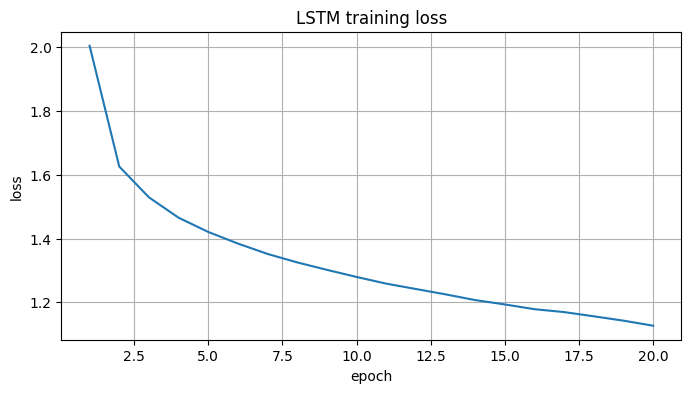

In [31]:
# Your beautiful code here

class CharLSTM(nn.Module):
    def __init__(self, n_tokens, hidden_size=256):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(n_tokens, self.hidden_size)
        self.cell = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, n_tokens)

    def initial_state(self, batch_size):
        h0 = torch.zeros(batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(batch_size, self.hidden_size, device=device)
        return torch.cat([h0, c0], dim=1)

    def forward(self, x_t, state):
        x_oh = self.emb(x_t)
        if x_oh.dim() == 3:
            if x_oh.size(1) == 1:
                x_oh = x_oh.squeeze(1)
            else:
                raise ValueError("LSTMCell expects single time step input, seq_len must be 1")
        elif x_oh.dim() == 1:
            x_oh = x_oh.unsqueeze(0)
        h, c = state[:, :self.hidden_size], state[:, self.hidden_size:]
        h, c = self.cell(x_oh, (h, c))
        logits = self.out(h)
        return logits, torch.cat([h, c], dim=1)

char_lstm = CharLSTM(n_tokens=n_tokens, hidden_size=HIDDEN_SIZE)
loss_history_lstm = train_char_model(char_lstm, out, epochs=20, steps_per_epoch=STEPS_PER_EPOCH, lr=3e-3)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history_lstm) + 1), loss_history_lstm)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("LSTM training loss")
plt.grid(True)
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [32]:
# Text generation with different temperature values here

temps = [0.1, 0.2, 0.5, 1.0, 2.0]

seed = "shall i compare thee to a summer's day? "
seed = (seed + " " * SEQ_LENGTH)[:SEQ_LENGTH]

for t in temps:
    print("\n" + "=" * 40)
    print("temperature =", t)
    print(generate_sample(char_lstm, seed_phrase=seed, max_length=400, temperature=t))

Streaming output truncated to the last 5000 lines.
         16, 16,  1, 31, 26,  1, 12,  1, 30, 32, 24, 24, 16, 29,  3, 30,  1, 15,
         12, 36, 11,  1, 20,  1, 30, 20, 25,  1, 13, 26, 29, 25,  6,  1, 16,  1,
         15, 32, 24, 13,  0,  1,  1, 35, 14, 33, 20, 20, 15, 16,  8,  0,  1,  1,
         12, 19, 26, 29, 16,  0,  1,  1, 13, 16, 12, 29, 20, 27, 16, 18,  3]]) torch.Size([1, 256])
(38,) 38
torch.Size([1, 89]) torch.Size([1, 1])
torch.Size([1, 90]) tensor([[30, 19, 12, 23, 23,  1, 20,  1, 14, 26, 24, 27, 12, 29, 16,  1, 31, 19,
         16, 16,  1, 31, 26,  1, 12,  1, 30, 32, 24, 24, 16, 29,  3, 30,  1, 15,
         12, 36, 11,  1, 20,  1, 30, 20, 25,  1, 13, 26, 29, 25,  6,  1, 16,  1,
         15, 32, 24, 13,  0,  1,  1, 35, 14, 33, 20, 20, 15, 16,  8,  0,  1,  1,
         12, 19, 26, 29, 16,  0,  1,  1, 13, 16, 12, 29, 20, 27, 16, 18,  3,  0]]) torch.Size([1, 256])
(38,) 38
torch.Size([1, 90]) torch.Size([1, 1])
torch.Size([1, 91]) tensor([[30, 19, 12, 23, 23,  1, 20,  1, 1

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [33]:
# Saving and loading code here

os.makedirs("checkpoints", exist_ok=True)

torch.save(char_rnn.state_dict(), "checkpoints/char_rnn.pt")
torch.save(char_lstm.state_dict(), "checkpoints/char_lstm.pt")

loaded_rnn = CharRNN(n_tokens=n_tokens, hidden_size=HIDDEN_SIZE)
loaded_rnn.load_state_dict(torch.load("checkpoints/char_rnn.pt", map_location=device))
loaded_rnn.eval()

loaded_lstm = CharLSTM(n_tokens=n_tokens, hidden_size=HIDDEN_SIZE)
loaded_lstm.load_state_dict(torch.load("checkpoints/char_lstm.pt", map_location=device))
loaded_lstm.eval()

seed = "shall i compare thee to a summer's day? "
seed = (seed + " " * SEQ_LENGTH)[:SEQ_LENGTH]

print("\nLoaded RNN sample:\n")
print(generate_sample(loaded_rnn, seed_phrase=seed, max_length=350, temperature=0.7))

print("\nLoaded LSTM sample:\n")
print(generate_sample(loaded_lstm, seed_phrase=seed, max_length=350, temperature=0.7))

Streaming output truncated to the last 5000 lines.
         16, 16,  1, 31, 26,  1, 12,  1, 30, 32, 24, 24, 16, 29,  3, 30,  1, 15,
         12, 36, 11,  1, 20, 25,  1, 19, 32, 30,  1, 12, 25, 15,  1, 13, 16, 30,
         32, 29, 30,  1, 26, 17,  1, 31, 19, 36,  1, 13, 16, 12, 32, 31, 36,  3,
         30,  1, 31, 19, 12, 30,  1, 20, 25,  1, 31, 19, 16, 25,  1, 34, 20, 23,
         23,  1, 13, 16, 12, 25, 31,  1, 13, 16,  1, 12, 25, 31,  1, 13, 26, 32,
         25, 31,  1, 25, 26, 31,  1, 30, 31,  1, 34, 20, 23, 23,  1, 12, 25, 15,
          1, 30, 19, 12, 15, 23, 16, 30,  1, 31, 19, 16, 16,  1, 31, 19, 16,  1,
         34, 26, 29, 30, 31, 26, 29,  1, 17, 26, 29,  1, 24, 36,  1, 30, 26, 32,
         29,  1, 30, 16, 16, 27, 23, 16, 30, 32, 30, 16,  1, 12, 15, 15,  1, 31,
         19, 16, 20,  1, 34, 20, 30, 19,  1, 24, 16,  6,  0,  1,  1, 15,  1, 12,
         23, 23,  1, 15, 16, 16, 15, 30,  1, 34, 26, 29, 31, 19,  1, 31, 19, 16,
         36,  1, 15, 16, 12, 29,  1, 30, 16, 25, 17, 12, 3

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)